# Fluzz — Détection de fraude bancaire  
**Partie 3 — Feature Engineering: Impact des features Amount et Time (Module 3)**

Ce notebook étudie l'impact des features `Amount` et `Time` sur les performances de détection de fraude.

**Hypothèse** : Les features `Amount` et `Time` sont corrélées avec certaines features V. Peut-on les supprimer sans perte de performance ?

**Comparaisons** :
- **Dataset complet** (avec Amount/Time) : Base vs Base+SDV
- **Dataset simplifié** (sans Amount/Time) : Base vs Base+SDV
- **Impact** de la suppression des features sur les performances

## 1. Configuration et chargement des données

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import SDV
try:
    from sdv.single_table import GaussianCopulaSynthesizer
    from sdv.metadata import SingleTableMetadata
    SDV_AVAILABLE = True
    print("✓ SDV importé avec succès")
except ImportError:
    SDV_AVAILABLE = False
    print("⚠️ SDV non disponible - installation requise: pip install sdv")

print("Bibliothèques chargées avec succès")

✓ SDV importé avec succès
Bibliothèques chargées avec succès


In [2]:
# Chargement du dataset original
df = pd.read_csv('../01_data/creditcard.csv')

print(f"Dataset chargé : {df.shape[0]} transactions, {df.shape[1]} features")
print(f"Features disponibles : {list(df.columns)}")
print(f"Taux de fraude : {df['Class'].mean()*100:.4f}%")

# Séparation des classes pour analyse
df_fraud = df[df['Class'] == 1].copy()
df_legit = df[df['Class'] == 0].copy()

print(f"\nTransactions légitimes : {len(df_legit)}")
print(f"Transactions frauduleuses : {len(df_fraud)}")
print(f"Ratio de déséquilibre : 1:{len(df_legit)//len(df_fraud)}")

Dataset chargé : 284807 transactions, 31 features
Features disponibles : ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Taux de fraude : 0.1727%

Transactions légitimes : 284315
Transactions frauduleuses : 492
Ratio de déséquilibre : 1:577


## 2. Analyse des corrélations entre Amount/Time et les features V

In [3]:
# Calcul de la matrice de corrélation
correlation_matrix = df.drop('Class', axis=1).corr()

# Focus sur les corrélations avec Amount et Time
amount_correlations = correlation_matrix['Amount'].abs().sort_values(ascending=False)
time_correlations = correlation_matrix['Time'].abs().sort_values(ascending=False)

print("TOP 10 CORRÉLATIONS AVEC AMOUNT:")
print("=" * 40)
for feature, corr in amount_correlations.head(10).items():
    print(f"{feature:12} : {corr:.4f}")

print("\nTOP 10 CORRÉLATIONS AVEC TIME:")
print("=" * 40)
for feature, corr in time_correlations.head(10).items():
    print(f"{feature:12} : {corr:.4f}")

# Seuil de corrélation significative
corr_threshold = 0.1
amount_high_corr = amount_correlations[amount_correlations > corr_threshold].drop('Amount')
time_high_corr = time_correlations[time_correlations > corr_threshold].drop('Time')

print(f"\n📊 FEATURES CORRÉLÉES AVEC AMOUNT (>{corr_threshold}):")
print(f"Nombre: {len(amount_high_corr)}")
if len(amount_high_corr) > 0:
    for feature, corr in amount_high_corr.items():
        print(f"  • {feature}: {corr:.4f}")

print(f"\n📊 FEATURES CORRÉLÉES AVEC TIME (>{corr_threshold}):")
print(f"Nombre: {len(time_high_corr)}")
if len(time_high_corr) > 0:
    for feature, corr in time_high_corr.items():
        print(f"  • {feature}: {corr:.4f}")

TOP 10 CORRÉLATIONS AVEC AMOUNT:
Amount       : 1.0000
V2           : 0.5314
V7           : 0.3973
V5           : 0.3864
V20          : 0.3394
V1           : 0.2277
V6           : 0.2160
V3           : 0.2109
V23          : 0.1126
V21          : 0.1060

TOP 10 CORRÉLATIONS AVEC TIME:
Time         : 1.0000
V3           : 0.4196
V11          : 0.2477
V25          : 0.2331
V15          : 0.1835
V5           : 0.1731
V22          : 0.1441
V12          : 0.1243
V1           : 0.1174
V4           : 0.1053

📊 FEATURES CORRÉLÉES AVEC AMOUNT (>0.1):
Nombre: 11
  • V2: 0.5314
  • V7: 0.3973
  • V5: 0.3864
  • V20: 0.3394
  • V1: 0.2277
  • V6: 0.2160
  • V3: 0.2109
  • V23: 0.1126
  • V21: 0.1060
  • V8: 0.1031
  • V10: 0.1015

📊 FEATURES CORRÉLÉES AVEC TIME (>0.1):
Nombre: 9
  • V3: 0.4196
  • V11: 0.2477
  • V25: 0.2331
  • V15: 0.1835
  • V5: 0.1731
  • V22: 0.1441
  • V12: 0.1243
  • V1: 0.1174
  • V4: 0.1053


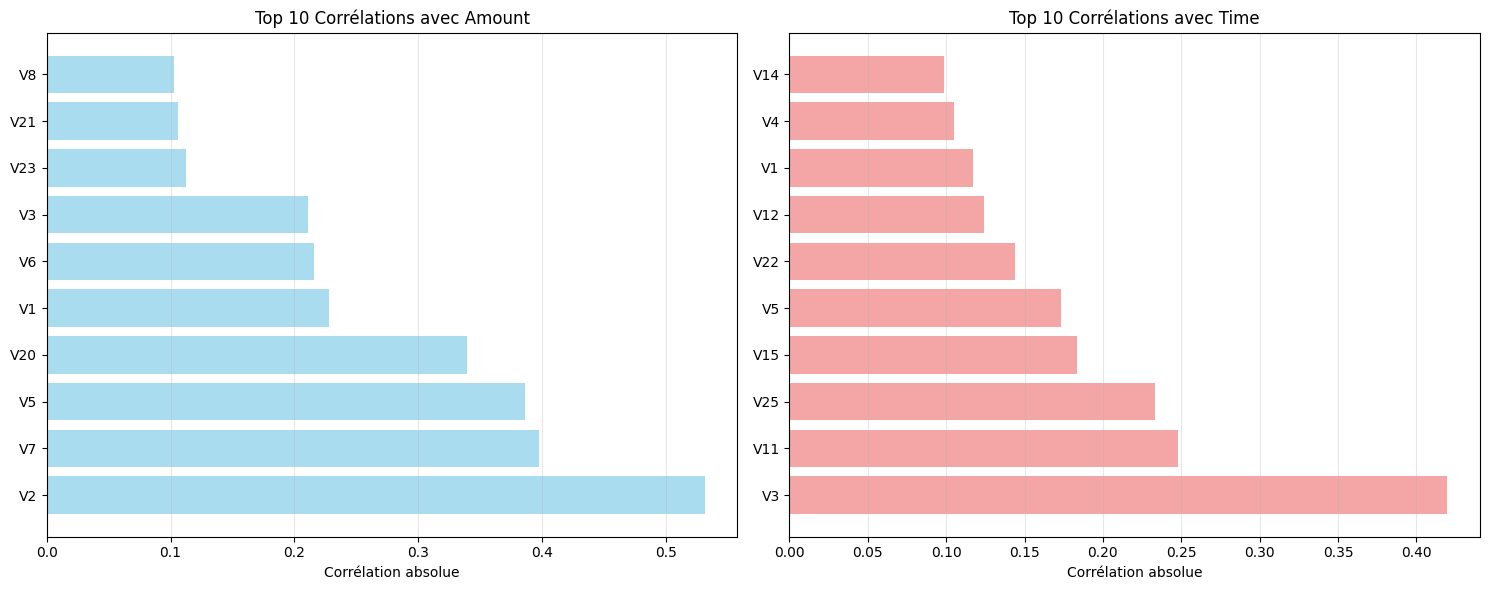


🔍 ANALYSE DES CORRÉLATIONS:
✓ Amount est corrélée avec 11 features V
✓ Time est corrélée avec 9 features V

💡 HYPOTHÈSE: Si Amount et Time sont redondantes avec les features V,
   leur suppression ne devrait pas impacter significativement les performances.


In [4]:
# Visualisation des corrélations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Corrélations avec Amount
amount_top = amount_correlations.drop('Amount').head(10)
ax1.barh(range(len(amount_top)), amount_top.values, color='skyblue', alpha=0.7)
ax1.set_yticks(range(len(amount_top)))
ax1.set_yticklabels(amount_top.index)
ax1.set_xlabel('Corrélation absolue')
ax1.set_title('Top 10 Corrélations avec Amount')
ax1.grid(axis='x', alpha=0.3)

# Corrélations avec Time
time_top = time_correlations.drop('Time').head(10)
ax2.barh(range(len(time_top)), time_top.values, color='lightcoral', alpha=0.7)
ax2.set_yticks(range(len(time_top)))
ax2.set_yticklabels(time_top.index)
ax2.set_xlabel('Corrélation absolue')
ax2.set_title('Top 10 Corrélations avec Time')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Analyse des résultats
print("\n🔍 ANALYSE DES CORRÉLATIONS:")
if len(amount_high_corr) > 0:
    print(f"✓ Amount est corrélée avec {len(amount_high_corr)} features V")
else:
    print("⚠️ Amount n'est pas fortement corrélée avec les features V")
    
if len(time_high_corr) > 0:
    print(f"✓ Time est corrélée avec {len(time_high_corr)} features V")
else:
    print("⚠️ Time n'est pas fortement corrélée avec les features V")

print(f"\n💡 HYPOTHÈSE: Si Amount et Time sont redondantes avec les features V,")
print(f"   leur suppression ne devrait pas impacter significativement les performances.")

## 3. Configuration des pipelines de modèles

In [5]:
# Configuration des pipelines (identiques à PART_2)
pipelines = {
    'Régression Logistique': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(
            class_weight='balanced',
            random_state=42,
            max_iter=1000
        ))
    ]),
    'Random Forest': Pipeline([
        ('classifier', RandomForestClassifier(
            class_weight='balanced',
            random_state=42,
            n_estimators=100
        ))
    ]),
    'MLP': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', MLPClassifier(
            hidden_layer_sizes=(100, 50),
            random_state=42,
            max_iter=500,
            early_stopping=True
        ))
    ])
}

print("Pipelines configurés :")
for name, pipeline in pipelines.items():
    print(f"• {name}: {[step[0] for step in pipeline.steps]}")

Pipelines configurés :
• Régression Logistique: ['scaler', 'classifier']
• Random Forest: ['classifier']
• MLP: ['scaler', 'classifier']


## 4. Fonction de génération de données synthétiques avec SDV

In [6]:
def generate_synthetic_data(df_fraud_only, num_synthetic=1000):
    """Génère des données synthétiques avec SDV"""
    if not SDV_AVAILABLE:
        print("SDV non disponible")
        return pd.DataFrame()
    
    print(f"Génération de {num_synthetic} fraudes synthétiques...")
    
    # Configuration SDV
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df_fraud_only)
    
    # Configuration du synthesizer
    synthesizer = GaussianCopulaSynthesizer(
        metadata=metadata,
        default_distribution='gaussian_kde'
    )
    
    # Si Amount est présent, utiliser une distribution gamma
    if 'Amount' in df_fraud_only.columns:
        synthesizer = GaussianCopulaSynthesizer(
            metadata=metadata,
            default_distribution='gaussian_kde',
            numerical_distributions={'Amount': 'gamma'}
        )
    
    # Entraînement et génération
    synthesizer.fit(df_fraud_only)
    synthetic_fraud = synthesizer.sample(num_rows=num_synthetic)
    
    print(f"✓ {len(synthetic_fraud)} transactions frauduleuses synthétiques générées")
    return synthetic_fraud

def evaluate_models(X_train, y_train, X_test, y_test, dataset_name):
    """Évalue les modèles sur un dataset donné"""
    results = []
    trained_models = {}
    
    print(f"\nÉVALUATION SUR {dataset_name.upper()}")
    print("=" * (len(dataset_name) + 15))
    print(f"Features: {X_train.shape[1]}")
    print(f"Training: {X_train.shape[0]} échantillons ({y_train.mean()*100:.3f}% fraudes)")
    print(f"Test: {X_test.shape[0]} échantillons ({y_test.mean()*100:.3f}% fraudes)")
    
    for name, pipeline in pipelines.items():
        print(f"\n--- {name} ---")
        
        # Clone et entraînement
        from sklearn.base import clone
        model = clone(pipeline)
        model.fit(X_train, y_train)
        trained_models[name] = model
        
        # Prédictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Métriques
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        
        results.append({
            'Dataset': dataset_name,
            'Modèle': name,
            'F1-Score': f1,
            'Précision': precision,
            'Rappel': recall,
            'PR-AUC': pr_auc
        })
        
        print(f"F1-Score : {f1:.4f}")
        print(f"Précision : {precision:.4f}")
        print(f"Rappel : {recall:.4f}")
        print(f"PR-AUC : {pr_auc:.4f}")
    
    return results, trained_models

print("Fonctions utilitaires définies")

Fonctions utilitaires définies


## 5. Expérimentation 1: Dataset COMPLET (avec Amount et Time)

In [7]:
# Préparation du dataset complet
print("🔬 EXPÉRIMENTATION 1: DATASET COMPLET (avec Amount et Time)")
print("=" * 70)

X_full = df.drop('Class', axis=1)
y_full = df['Class']

print(f"Features utilisées: {list(X_full.columns)}")
print(f"Nombre de features: {X_full.shape[1]}")

# Division train/test
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.3, random_state=42, stratify=y_full
)

print(f"\nDivision train/test:")
print(f"Train: {X_train_full.shape[0]} échantillons")
print(f"Test: {X_test_full.shape[0]} échantillons")

🔬 EXPÉRIMENTATION 1: DATASET COMPLET (avec Amount et Time)
Features utilisées: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
Nombre de features: 30

Division train/test:
Train: 199364 échantillons
Test: 85443 échantillons


In [8]:
# 5.1 Modèles de base sur dataset complet
results_full_base, models_full_base = evaluate_models(
    X_train_full, y_train_full, X_test_full, y_test_full, 
    "Complet (Base)"
)


ÉVALUATION SUR COMPLET (BASE)
Features: 30
Training: 199364 échantillons (0.173% fraudes)
Test: 85443 échantillons (0.173% fraudes)

--- Régression Logistique ---
F1-Score : 0.1247
Précision : 0.0671
Rappel : 0.8784
PR-AUC : 0.7050

--- Random Forest ---
F1-Score : 0.8157
Précision : 0.9720
Rappel : 0.7027
PR-AUC : 0.8059

--- MLP ---
F1-Score : 0.8000
Précision : 0.9060
Rappel : 0.7162
PR-AUC : 0.7893


In [9]:
# 5.2 Génération de données synthétiques pour le dataset complet
if SDV_AVAILABLE:
    # Fraudes du training set seulement
    train_indices = X_train_full.index
    df_fraud_train_full = df.loc[train_indices][df.loc[train_indices]['Class'] == 1]
    
    print(f"\nFraudes dans le training set: {len(df_fraud_train_full)}")
    
    # Génération de données synthétiques
    synthetic_fraud_full = generate_synthetic_data(df_fraud_train_full, num_synthetic=1000)
    
    if len(synthetic_fraud_full) > 0:
        # Création du dataset d'entraînement augmenté
        df_train_full = df.loc[train_indices].copy()
        df_train_augmented_full = pd.concat([
            df_train_full,
            synthetic_fraud_full
        ], ignore_index=True)
        
        X_train_aug_full = df_train_augmented_full.drop('Class', axis=1)
        y_train_aug_full = df_train_augmented_full['Class']
        
        print(f"Dataset d'entraînement augmenté: {len(df_train_augmented_full)} échantillons")
        print(f"Nouveau taux de fraude: {y_train_aug_full.mean()*100:.3f}%")
    else:
        X_train_aug_full = X_train_full
        y_train_aug_full = y_train_full
else:
    X_train_aug_full = X_train_full
    y_train_aug_full = y_train_full


Fraudes dans le training set: 344
Génération de 1000 fraudes synthétiques...
✓ 1000 transactions frauduleuses synthétiques générées
Dataset d'entraînement augmenté: 200364 échantillons
Nouveau taux de fraude: 0.671%


In [10]:
# 5.3 Modèles avec SDV sur dataset complet
if SDV_AVAILABLE and len(synthetic_fraud_full) > 0:
    results_full_sdv, models_full_sdv = evaluate_models(
        X_train_aug_full, y_train_aug_full, X_test_full, y_test_full,
        "Complet (SDV)"
    )
else:
    print("SDV non disponible - pas de modèles augmentés")
    results_full_sdv = []


ÉVALUATION SUR COMPLET (SDV)
Features: 30
Training: 200364 échantillons (0.671% fraudes)
Test: 85443 échantillons (0.173% fraudes)

--- Régression Logistique ---
F1-Score : 0.1239
Précision : 0.0667
Rappel : 0.8784
PR-AUC : 0.5966

--- Random Forest ---
F1-Score : 0.8413
Précision : 0.9268
Rappel : 0.7703
PR-AUC : 0.8276

--- MLP ---
F1-Score : 0.8188
Précision : 0.8828
Rappel : 0.7635
PR-AUC : 0.8040


## 6. Expérimentation 2: Dataset SIMPLIFIÉ (sans Amount et Time)

In [11]:
# Préparation du dataset simplifié
print("🔬 EXPÉRIMENTATION 2: DATASET SIMPLIFIÉ (sans Amount et Time)")
print("=" * 70)

# Suppression d'Amount et Time
features_to_remove = ['Amount', 'Time']
features_to_keep = [col for col in df.columns if col not in features_to_remove + ['Class']]

X_simple = df[features_to_keep].copy()
y_simple = df['Class'].copy()

print(f"Features supprimées: {features_to_remove}")
print(f"Features restantes: {len(features_to_keep)} (V1 à V28)")
print(f"Features utilisées: {list(X_simple.columns)[:5]}...{list(X_simple.columns)[-5:]}")

# Division train/test (mêmes indices que le dataset complet)
X_train_simple = X_simple.loc[X_train_full.index]
X_test_simple = X_simple.loc[X_test_full.index]
y_train_simple = y_simple.loc[y_train_full.index]
y_test_simple = y_simple.loc[y_test_full.index]

print(f"\nDivision train/test (mêmes indices):")
print(f"Train: {X_train_simple.shape[0]} échantillons")
print(f"Test: {X_test_simple.shape[0]} échantillons")

🔬 EXPÉRIMENTATION 2: DATASET SIMPLIFIÉ (sans Amount et Time)
Features supprimées: ['Amount', 'Time']
Features restantes: 28 (V1 à V28)
Features utilisées: ['V1', 'V2', 'V3', 'V4', 'V5']...['V24', 'V25', 'V26', 'V27', 'V28']

Division train/test (mêmes indices):
Train: 199364 échantillons
Test: 85443 échantillons


In [12]:
# 6.1 Modèles de base sur dataset simplifié
results_simple_base, models_simple_base = evaluate_models(
    X_train_simple, y_train_simple, X_test_simple, y_test_simple,
    "Simplifié (Base)"
)


ÉVALUATION SUR SIMPLIFIÉ (BASE)
Features: 28
Training: 199364 échantillons (0.173% fraudes)
Test: 85443 échantillons (0.173% fraudes)

--- Régression Logistique ---
F1-Score : 0.1197
Précision : 0.0642
Rappel : 0.8784
PR-AUC : 0.6983

--- Random Forest ---
F1-Score : 0.8157
Précision : 0.9720
Rappel : 0.7027
PR-AUC : 0.8059

--- MLP ---
F1-Score : 0.7912
Précision : 0.8640
Rappel : 0.7297
PR-AUC : 0.7926


In [13]:
# 6.2 Génération de données synthétiques pour le dataset simplifié
if SDV_AVAILABLE:
    # Fraudes du training set (sans Amount et Time)
    df_fraud_train_simple = df.loc[train_indices][df.loc[train_indices]['Class'] == 1][features_to_keep + ['Class']]
    
    print(f"\nFraudes dans le training set (simplifié): {len(df_fraud_train_simple)}")
    
    # Génération de données synthétiques
    synthetic_fraud_simple = generate_synthetic_data(df_fraud_train_simple, num_synthetic=1000)
    
    if len(synthetic_fraud_simple) > 0:
        # Création du dataset d'entraînement augmenté (simplifié)
        df_train_simple = df.loc[train_indices][features_to_keep + ['Class']].copy()
        df_train_augmented_simple = pd.concat([
            df_train_simple,
            synthetic_fraud_simple
        ], ignore_index=True)
        
        X_train_aug_simple = df_train_augmented_simple.drop('Class', axis=1)
        y_train_aug_simple = df_train_augmented_simple['Class']
        
        print(f"Dataset d'entraînement augmenté (simplifié): {len(df_train_augmented_simple)} échantillons")
        print(f"Nouveau taux de fraude: {y_train_aug_simple.mean()*100:.3f}%")
    else:
        X_train_aug_simple = X_train_simple
        y_train_aug_simple = y_train_simple
else:
    X_train_aug_simple = X_train_simple
    y_train_aug_simple = y_train_simple


Fraudes dans le training set (simplifié): 344
Génération de 1000 fraudes synthétiques...
✓ 1000 transactions frauduleuses synthétiques générées
Dataset d'entraînement augmenté (simplifié): 200364 échantillons
Nouveau taux de fraude: 0.671%


In [14]:
# 6.3 Modèles avec SDV sur dataset simplifié
if SDV_AVAILABLE and len(synthetic_fraud_simple) > 0:
    results_simple_sdv, models_simple_sdv = evaluate_models(
        X_train_aug_simple, y_train_aug_simple, X_test_simple, y_test_simple,
        "Simplifié (SDV)"
    )
else:
    print("SDV non disponible - pas de modèles augmentés")
    results_simple_sdv = []


ÉVALUATION SUR SIMPLIFIÉ (SDV)
Features: 28
Training: 200364 échantillons (0.671% fraudes)
Test: 85443 échantillons (0.173% fraudes)

--- Régression Logistique ---
F1-Score : 0.1121
Précision : 0.0599
Rappel : 0.8784
PR-AUC : 0.6157

--- Random Forest ---
F1-Score : 0.8382
Précision : 0.9194
Rappel : 0.7703
PR-AUC : 0.8142

--- MLP ---
F1-Score : 0.8000
Précision : 0.7895
Rappel : 0.8108
PR-AUC : 0.8044


## 7. Comparaison des résultats et analyse

In [15]:
# Consolidation de tous les résultats
all_results = results_full_base + results_full_sdv + results_simple_base + results_simple_sdv
results_df = pd.DataFrame(all_results)

print("📊 RÉSULTATS COMPLETS - COMPARAISON DES DATASETS")
print("=" * 60)
if len(results_df) > 0:
    # Réorganisation pour une meilleure lisibilité
    results_pivot = results_df.pivot_table(
        index='Modèle', 
        columns='Dataset', 
        values=['F1-Score', 'Précision', 'Rappel', 'PR-AUC']
    ).round(4)
    
    print(results_pivot)
else:
    print("Aucun résultat à afficher")

📊 RÉSULTATS COMPLETS - COMPARAISON DES DATASETS
                            F1-Score                                 \
Dataset               Complet (Base) Complet (SDV) Simplifié (Base)   
Modèle                                                                
MLP                           0.8000        0.8188           0.7912   
Random Forest                 0.8157        0.8413           0.8157   
Régression Logistique         0.1247        0.1239           0.1197   

                                              PR-AUC                \
Dataset               Simplifié (SDV) Complet (Base) Complet (SDV)   
Modèle                                                               
MLP                            0.8000         0.7893        0.8040   
Random Forest                  0.8382         0.8059        0.8276   
Régression Logistique          0.1121         0.7050        0.5966   

                                                            Précision  \
Dataset               Simplifié

In [16]:
# Analyse détaillée des impacts
if len(results_df) > 0:
    print("\n🎯 ANALYSE DE L'IMPACT DE LA SUPPRESSION D'AMOUNT ET TIME")
    print("=" * 70)
    
    # Groupement par modèle pour comparaison
    for model_name in ['Régression Logistique', 'Random Forest', 'MLP']:
        model_results = results_df[results_df['Modèle'] == model_name]
        
        if len(model_results) > 0:
            print(f"\n--- {model_name} ---")
            
            # Comparaison Base: Complet vs Simplifié
            base_full = model_results[model_results['Dataset'] == 'Complet (Base)']
            base_simple = model_results[model_results['Dataset'] == 'Simplifié (Base)']
            
            if len(base_full) > 0 and len(base_simple) > 0:
                f1_full = base_full['F1-Score'].iloc[0]
                f1_simple = base_simple['F1-Score'].iloc[0]
                f1_diff = f1_simple - f1_full
                f1_pct = (f1_diff / f1_full * 100) if f1_full > 0 else 0
                
                pr_auc_full = base_full['PR-AUC'].iloc[0]
                pr_auc_simple = base_simple['PR-AUC'].iloc[0]
                pr_auc_diff = pr_auc_simple - pr_auc_full
                
                print(f"  Base (sans Amount/Time):")
                print(f"    F1-Score  : {f1_full:.4f} → {f1_simple:.4f} ({f1_diff:+.4f}, {f1_pct:+.1f}%)")
                print(f"    PR-AUC    : {pr_auc_full:.4f} → {pr_auc_simple:.4f} ({pr_auc_diff:+.4f})")
            
            # Comparaison SDV: Complet vs Simplifié
            sdv_full = model_results[model_results['Dataset'] == 'Complet (SDV)']
            sdv_simple = model_results[model_results['Dataset'] == 'Simplifié (SDV)']
            
            if len(sdv_full) > 0 and len(sdv_simple) > 0:
                f1_full_sdv = sdv_full['F1-Score'].iloc[0]
                f1_simple_sdv = sdv_simple['F1-Score'].iloc[0]
                f1_diff_sdv = f1_simple_sdv - f1_full_sdv
                f1_pct_sdv = (f1_diff_sdv / f1_full_sdv * 100) if f1_full_sdv > 0 else 0
                
                pr_auc_full_sdv = sdv_full['PR-AUC'].iloc[0]
                pr_auc_simple_sdv = sdv_simple['PR-AUC'].iloc[0]
                pr_auc_diff_sdv = pr_auc_simple_sdv - pr_auc_full_sdv
                
                print(f"  SDV (sans Amount/Time):")
                print(f"    F1-Score  : {f1_full_sdv:.4f} → {f1_simple_sdv:.4f} ({f1_diff_sdv:+.4f}, {f1_pct_sdv:+.1f}%)")
                print(f"    PR-AUC    : {pr_auc_full_sdv:.4f} → {pr_auc_simple_sdv:.4f} ({pr_auc_diff_sdv:+.4f})")
            
            # Évaluation de l'impact
            if len(base_full) > 0 and len(base_simple) > 0:
                if abs(f1_diff) < 0.01:
                    print(f"  ✅ Impact négligeable - Amount/Time peuvent être supprimées")
                elif f1_diff < -0.05:
                    print(f"  ❌ Dégradation significative - Amount/Time sont importantes")
                elif f1_diff > 0.01:
                    print(f"  🚀 Amélioration - La suppression d'Amount/Time aide !")
                else:
                    print(f"  ⚠️ Impact modéré - À évaluer selon le contexte")

# Conclusion générale
print("\n🎯 CONCLUSIONS GÉNÉRALES")
print("=" * 30)
print("1. Les features Amount et Time sont-elles redondantes ?")
print("2. Peut-on simplifier le modèle sans perte de performance ?")
print("3. L'augmentation SDV est-elle plus efficace sur le dataset simplifié ?")
print("\n💡 Réponses basées sur les résultats ci-dessus.")


🎯 ANALYSE DE L'IMPACT DE LA SUPPRESSION D'AMOUNT ET TIME

--- Régression Logistique ---
  Base (sans Amount/Time):
    F1-Score  : 0.1247 → 0.1197 (-0.0050, -4.0%)
    PR-AUC    : 0.7050 → 0.6983 (-0.0067)
  SDV (sans Amount/Time):
    F1-Score  : 0.1239 → 0.1121 (-0.0119, -9.6%)
    PR-AUC    : 0.5966 → 0.6157 (+0.0191)
  ✅ Impact négligeable - Amount/Time peuvent être supprimées

--- Random Forest ---
  Base (sans Amount/Time):
    F1-Score  : 0.8157 → 0.8157 (+0.0000, +0.0%)
    PR-AUC    : 0.8059 → 0.8059 (-0.0001)
  SDV (sans Amount/Time):
    F1-Score  : 0.8413 → 0.8382 (-0.0031, -0.4%)
    PR-AUC    : 0.8276 → 0.8142 (-0.0134)
  ✅ Impact négligeable - Amount/Time peuvent être supprimées

--- MLP ---
  Base (sans Amount/Time):
    F1-Score  : 0.8000 → 0.7912 (-0.0088, -1.1%)
    PR-AUC    : 0.7893 → 0.7926 (+0.0033)
  SDV (sans Amount/Time):
    F1-Score  : 0.8188 → 0.8000 (-0.0188, -2.3%)
    PR-AUC    : 0.8040 → 0.8044 (+0.0004)
  ✅ Impact négligeable - Amount/Time peuvent êtr

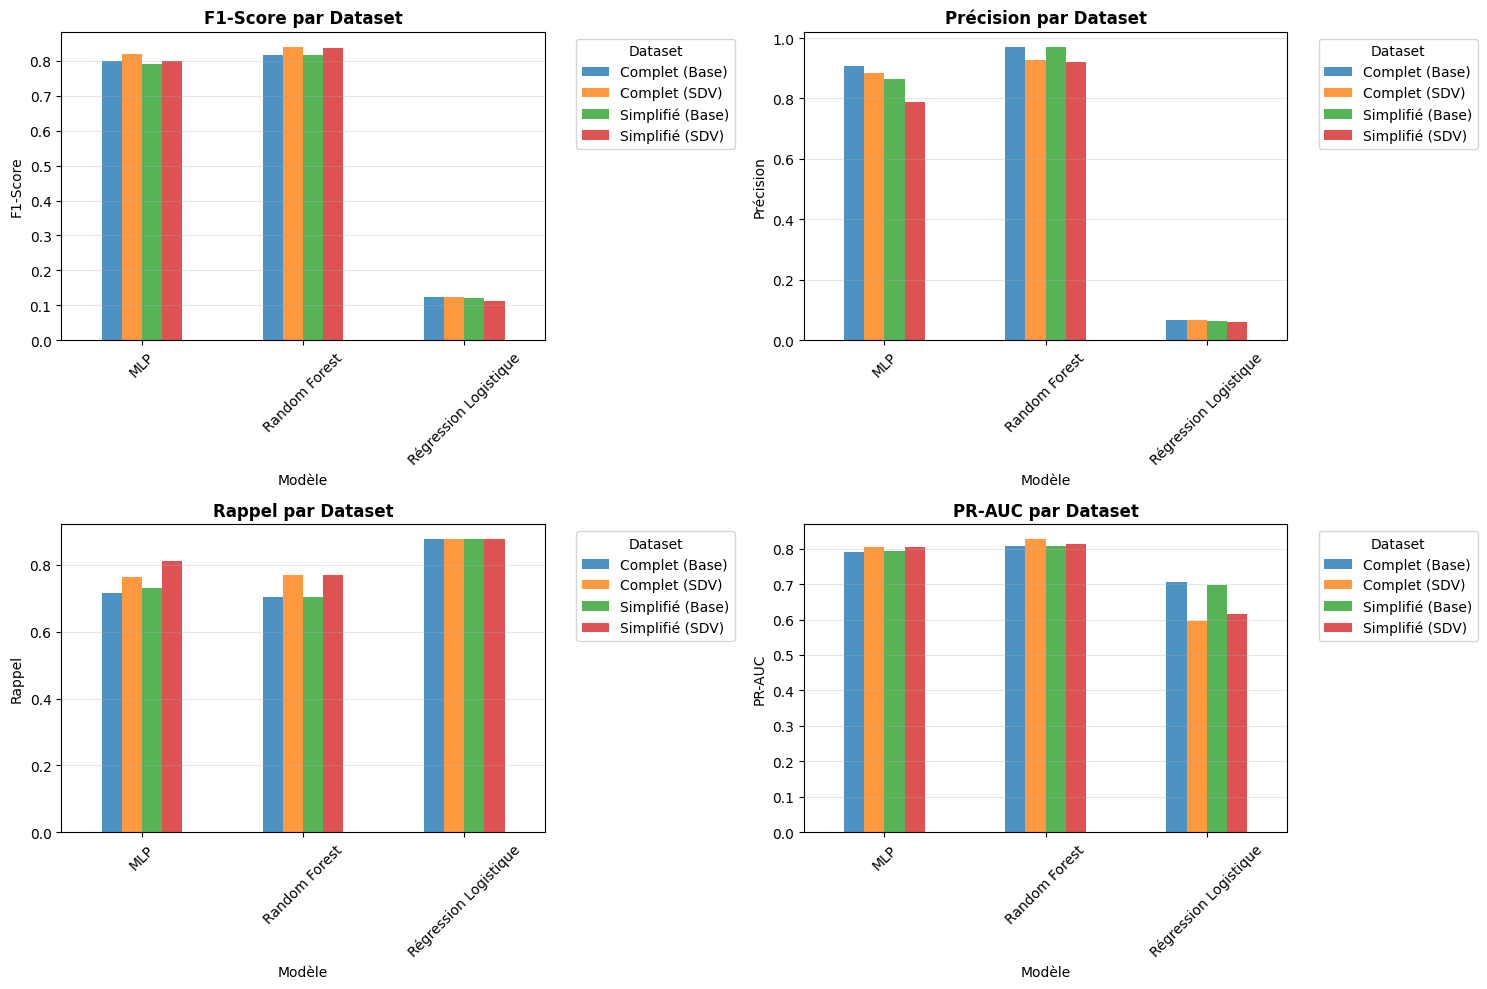

📈 Les graphiques montrent l'impact de chaque configuration sur les métriques.
   • Comparer les barres pour voir l'effet de la suppression d'Amount/Time
   • Évaluer l'efficacité de SDV sur chaque type de dataset


In [17]:
# Visualisation comparative
if len(results_df) > 0:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    metrics = ['F1-Score', 'Précision', 'Rappel', 'PR-AUC']
    axes = [ax1, ax2, ax3, ax4]
    
    for metric, ax in zip(metrics, axes):
        # Préparation des données pour le graphique
        pivot_data = results_df.pivot_table(
            index='Modèle', 
            columns='Dataset', 
            values=metric
        ).fillna(0)
        
        # Graphique en barres
        pivot_data.plot(kind='bar', ax=ax, alpha=0.8)
        ax.set_title(f'{metric} par Dataset', fontweight='bold')
        ax.set_xlabel('Modèle')
        ax.set_ylabel(metric)
        ax.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(axis='y', alpha=0.3)
        
        # Rotation des labels
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("📈 Les graphiques montrent l'impact de chaque configuration sur les métriques.")
    print("   • Comparer les barres pour voir l'effet de la suppression d'Amount/Time")
    print("   • Évaluer l'efficacité de SDV sur chaque type de dataset")